In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt  # thêm import này để vẽ biểu đồ

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier

from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    average_precision_score,
    accuracy_score,
    precision_recall_fscore_support,
)

In [2]:
DATA_DIR = "datasets/"

student_info = pd.read_csv(
    DATA_DIR + "studentInfo.csv",
    usecols=[
        "id_student",
        "code_module",
        "code_presentation",
        "final_result",
        "gender",
        "region",
        "age_band",
        "highest_education",
        "imd_band",
        "num_of_prev_attempts",
        "studied_credits",
        "disability",
    ],
)

student_reg = pd.read_csv(
    DATA_DIR + "studentRegistration.csv",
    usecols=[
        "id_student",
        "code_module",
        "code_presentation",
        "date_registration",
        "date_unregistration",
    ],
)

student_vle = pd.read_csv(
    DATA_DIR + "studentVle.csv",
    usecols=[
        "id_student",
        "code_module",
        "code_presentation",
        "id_site",
        "date",
        "sum_click",
    ],
)

student_ass = pd.read_csv(
    DATA_DIR + "studentAssessment.csv",
    usecols=[
        "id_assessment",
        "id_student",
        "date_submitted",
        "is_banked",
        "score",
    ],
)

In [3]:
MODULE = "EEE"
PRESENTATION = "2014J"
EARLY_DAYS = 14  # chỉ dùng 14 ngày đầu cho early-warning

students = student_info[
    (student_info["code_module"] == MODULE)
    & (student_info["code_presentation"] == PRESENTATION)
].copy()

# Label: Withdrawn = dropout (1), còn lại = 0
students["dropout"] = np.where(students["final_result"] == "Withdrawn", 1, 0)

print("Số lượng sinh viên:", len(students))
print("Tỉ lệ dropout:", students["dropout"].mean())

Số lượng sinh viên: 1188
Tỉ lệ dropout: 0.25757575757575757


In [4]:
reg = student_reg[
    (student_reg["code_module"] == MODULE)
    & (student_reg["code_presentation"] == PRESENTATION)
    & (student_reg["id_student"].isin(students["id_student"]))
].copy()

reg_features = reg[["id_student", "date_registration"]].copy()
reg_features = reg_features.rename(columns={"date_registration": "reg_day"})
reg_features["registered_before_start"] = (reg_features["reg_day"] < 0).astype(int)

In [5]:
vle = student_vle[
    (student_vle["code_module"] == MODULE)
    & (student_vle["code_presentation"] == PRESENTATION)
    & (student_vle["id_student"].isin(students["id_student"]))
    & (student_vle["date"] >= 0)
    & (student_vle["date"] <= EARLY_DAYS)
].copy()

# 4.1 Tổng quan hoạt động
vle_agg = (
    vle.groupby("id_student")
    .agg(
        total_clicks=("sum_click", "sum"),
        active_days=("date", "nunique"),
    )
    .reset_index()
)

vle_agg["avg_clicks_per_day"] = vle_agg["total_clicks"] / EARLY_DAYS
vle_agg["avg_clicks_per_active_day"] = (
    vle_agg["total_clicks"] / vle_agg["active_days"].replace(0, np.nan)
)
vle_agg["avg_clicks_per_active_day"] = vle_agg["avg_clicks_per_active_day"].fillna(0)

# 4.2 Click theo từng giai đoạn (0–7, 8–14)
def clicks_in_window(df, start_day, end_day, col_name):
    w = (
        df[(df["date"] >= start_day) & (df["date"] <= end_day)]
        .groupby("id_student")["sum_click"]
        .sum()
        .reset_index()
        .rename(columns={"sum_click": col_name})
    )
    return w

w1 = clicks_in_window(vle, 0, 7, "clicks_0_7")
w2 = clicks_in_window(vle, 8, EARLY_DAYS, "clicks_8_14")

for w in [w1, w2]:
    vle_agg = vle_agg.merge(w, on="id_student", how="left")

vle_agg = vle_agg.fillna(0)

vle_agg["trend_click"] = vle_agg["clicks_8_14"] - vle_agg["clicks_0_7"] 
# Hoặc tỷ lệ thay đổi (tránh chia cho 0)
vle_agg["ratio_click"] = (vle_agg["clicks_8_14"] + 1) / (vle_agg["clicks_0_7"] + 1)

# 4.3 days_since_last_login & inactivity_streak trong 14 ngày
last_active = (
    vle.groupby("id_student")["date"]
    .max()
    .reset_index()
    .rename(columns={"date": "last_active_day"})
)
last_active["days_since_last_login"] = EARLY_DAYS - last_active["last_active_day"]

vle_days = (
    vle.groupby("id_student")["date"]
    .apply(lambda x: sorted(x.unique()))
    .reset_index()
    .rename(columns={"date": "active_days_list"})
)

def compute_inactivity_streak(days_list, max_day):
    if not days_list:
        return max_day + 1
    active_set = set(days_list)
    streak = 0
    current_day = max_day
    while current_day >= 0 and current_day not in active_set:
        streak += 1
        current_day -= 1
    return streak

vle_days["inactivity_streak"] = vle_days["active_days_list"].apply(
    lambda lst: compute_inactivity_streak(lst, EARLY_DAYS)
)

extra_activity = last_active[["id_student", "days_since_last_login"]].merge(
    vle_days[["id_student", "inactivity_streak"]], on="id_student", how="outer"
)

vle_agg = vle_agg.merge(extra_activity, on="id_student", how="left")


In [6]:
ass = student_ass[
    (student_ass["id_student"].isin(students["id_student"]))
    & (student_ass["date_submitted"] >= 0)
    & (student_ass["date_submitted"] <= EARLY_DAYS)
].copy()

ass_agg = (
    ass.groupby("id_student")
    .agg(
        num_assessments=("id_assessment", "nunique"),
        avg_score=("score", "mean"),
        max_score=("score", "max"),
        min_score=("score", "min"),
        score_std=("score", "std"),
    )
    .reset_index()
)

last_score = (
    ass.sort_values(["id_student", "date_submitted"])
    .groupby("id_student")["score"]
    .last()
    .reset_index()
    .rename(columns={"score": "last_score"})
)

ass_agg = ass_agg.merge(last_score, on="id_student", how="left")

PASS_THRESHOLD = 40
ass["is_pass"] = (ass["score"] >= PASS_THRESHOLD).astype(int)

pass_rate = (
    ass.groupby("id_student")["is_pass"]
    .mean()
    .reset_index()
    .rename(columns={"is_pass": "pass_rate"})
)

ass_agg = ass_agg.merge(pass_rate, on="id_student", how="left")
ass_agg = ass_agg.fillna(0)

In [7]:
data = (
    students.merge(reg_features, on="id_student", how="left")
    .merge(vle_agg, on="id_student", how="left")
    .merge(ass_agg, on="id_student", how="left")
)

numeric_cols_to_fill = [
    "reg_day",
    "registered_before_start",
    "total_clicks",
    "active_days",
    "avg_clicks_per_day",
    "avg_clicks_per_active_day",
    "clicks_0_7",
    "clicks_8_14",
    "trend_click",
    "ratio_click",
    "num_assessments",
    "avg_score",
    "max_score",
    # "min_score",
    # "score_std",
    "last_score",
    "days_since_last_login",
    "inactivity_streak",
    "pass_rate",
]

for col in numeric_cols_to_fill:
    if col in data.columns:
        data[col] = data[col].fillna(0)

print("NaN còn lại:")
print(data.isna().sum())


NaN còn lại:
code_module                     0
code_presentation               0
id_student                      0
gender                          0
region                          0
highest_education               0
imd_band                       47
age_band                        0
num_of_prev_attempts            0
studied_credits                 0
disability                      0
final_result                    0
dropout                         0
reg_day                         0
registered_before_start         0
total_clicks                    0
active_days                     0
avg_clicks_per_day              0
avg_clicks_per_active_day       0
clicks_0_7                      0
clicks_8_14                     0
trend_click                     0
ratio_click                     0
days_since_last_login           0
inactivity_streak               0
num_assessments                 0
avg_score                       0
max_score                       0
min_score                    1183
s

In [8]:
feature_cols_num = [
    # Hoạt động
    "total_clicks",
    "active_days",
    "avg_clicks_per_day",
    "avg_clicks_per_active_day",
    "clicks_0_7",
    "clicks_8_14",
    # Quiz / điểm số
    "num_assessments",
    "avg_score",
    "trend_click",
    "ratio_click",
    "max_score",
    # "min_score",
    # "score_std",
    "last_score",
    "pass_rate",
    # Thời gian & gián đoạn
    "reg_day",
    "registered_before_start",
    "days_since_last_login",
    "inactivity_streak",
]

feature_cols_cat = [
    "gender",
    "age_band",
]

X = data[feature_cols_num + feature_cols_cat]
y = data["dropout"]

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.3,
    random_state=42,
    stratify=y,
)

print("Shape train/test:", X_train.shape, X_test.shape)
print("Dropout ratio train/test:", y_train.mean(), y_test.mean())


Shape train/test: (831, 19) (357, 19)
Dropout ratio train/test: 0.2575210589651023 0.25770308123249297


In [9]:
numeric_transformer = Pipeline(
    steps=[
        ("scaler", StandardScaler()),
    ]
)

categorical_transformer = Pipeline(
    steps=[
        ("onehot", OneHotEncoder(handle_unknown="ignore")),
    ]
)

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, feature_cols_num),
        ("cat", categorical_transformer, feature_cols_cat),
    ]
)

In [10]:
models = {
    # Logistic Regression: Thêm class_weight='balanced'
    "LogisticRegression": LogisticRegression(
        penalty="l2",         # Đổi sang l2 thường ổn định hơn cho dữ liệu ít feature
        solver="lbfgs",
        class_weight="balanced", # <--- QUAN TRỌNG: Cân bằng trọng số lớp
        max_iter=2000,
    ),
    
    # RandomForest: Tăng độ sâu và số cây, thêm class_weight
    "RandomForest": RandomForestClassifier(
        criterion="gini",
        n_estimators=200,      # Tăng từ 50 lên 200
        max_depth=10,          # Tăng từ 3 lên 10 (hoặc None) để học sâu hơn
        min_samples_leaf=4,    # Giảm từ 10 xuống 4 để bắt pattern nhỏ hơn
        min_samples_split=10,  # Giảm từ 50 xuống 10
        class_weight="balanced", # <--- QUAN TRỌNG
        random_state=42
    ),
    
    # GradientBoosting: Tăng mạnh n_estimators (GB ko có class_weight trực tiếp, phải chỉnh mẫu hoặc dùng XGBoost/LGBM)
    # Nhưng ta sẽ chỉnh learning rate và số cây để nó học kỹ hơn
    "GradientBoosting": GradientBoostingClassifier(
        learning_rate=0.05,    # Tăng nhẹ hoặc giữ nguyên
        n_estimators=150,      # Tăng từ 10 lên 150 (10 là quá ít)
        max_depth=5,           # Tăng độ sâu
        min_samples_split=10,
        subsample=0.8,         # Giúp giảm overfitting
        random_state=42
    ),
    
    # MLP: Tăng max_iter
    "MLPClassifier": MLPClassifier(
        hidden_layer_sizes=(64, 32), # Thử kiến trúc sâu hơn chút
        activation='relu',
        solver='adam',
        alpha=0.001,
        learning_rate_init=0.01,
        max_iter=1000,
        early_stopping=True,
        random_state=42
    ),
}

In [11]:
import numpy as np
from sklearn.metrics import f1_score

results = {}
thresholds = np.arange(0.1, 0.95, 0.05) # Quét từ 0.1 đến 0.9

print(f"{'MODEL':<20} | {'BEST THRESH':<12} | {'DEFAULT F1':<10} | {'OPTIMIZED F1':<12}")
print("-" * 65)

for name, clf in models.items():
    # 1. Tạo và huấn luyện pipeline
    pipe = Pipeline([
        ("prep", preprocessor),
        ("clf", clf),
    ])
    pipe.fit(X_train, y_train)

    # 2. Dự đoán xác suất (proba)
    # Lưu ý: Cần lấy cột [1] là xác suất của lớp Positive (Dropout)
    y_proba = pipe.predict_proba(X_test)[:, 1]
    
    # --- TỐI ƯU THRESHOLD ---
    best_f1 = 0
    best_thresh = 0.5
    
    for thresh in thresholds:
        # Chuyển xác suất thành nhãn 0/1 dựa trên ngưỡng thresh
        y_pred_t = (y_proba >= thresh).astype(int)
        f1_t = f1_score(y_test, y_pred_t)
        
        if f1_t > best_f1:
            best_f1 = f1_t
            best_thresh = thresh
    
    # 3. Tính toán lại Metrics với ngưỡng tốt nhất vừa tìm được
    y_pred_opt = (y_proba >= best_thresh).astype(int)
    
    acc = accuracy_score(y_test, y_pred_opt)
    prec, rec, f1, _ = precision_recall_fscore_support(
        y_test, y_pred_opt, labels=[1], zero_division=0
    )
    auc = roc_auc_score(y_test, y_proba)
    avgp = average_precision_score(y_test, y_proba)
    
    # Lấy F1 mặc định (ngưỡng 0.5) để so sánh chơi
    y_pred_default = (y_proba >= 0.5).astype(int)
    f1_default = f1_score(y_test, y_pred_default)

    print(f"{name:<20} | {best_thresh:<12.2f} | {f1_default:<10.4f} | {f1[0]:<12.4f}")

    # 4. Lưu kết quả
    results[name] = {
        "best_thresh": best_thresh,
        "accuracy": acc,
        "precision": prec[0],
        "recall": rec[0],
        "f1_opt": f1[0],     # F1 đã tối ưu
        "roc_auc": auc,
        "avg_precision": avgp,
    }

print("-" * 65)
results_df = pd.DataFrame(results).T
print("\nBẢNG KẾT QUẢ CHI TIẾT SAU KHI TỐI ƯU:")
results_df

MODEL                | BEST THRESH  | DEFAULT F1 | OPTIMIZED F1
-----------------------------------------------------------------
LogisticRegression   | 0.60         | 0.5511     | 0.6127      


/Users/nami/lms/engtastic_ai/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(


RandomForest         | 0.35         | 0.5316     | 0.5526      
GradientBoosting     | 0.20         | 0.5139     | 0.5200      
MLPClassifier        | 0.30         | 0.5191     | 0.6230      
-----------------------------------------------------------------

BẢNG KẾT QUẢ CHI TIẾT SAU KHI TỐI ƯU:


,best_thresh,accuracy,precision,recall,f1_opt,roc_auc,avg_precision
LogisticRegression,0.60,0.812325,0.654321,0.576087,0.612717,0.795160,0.674431
RandomForest,0.35,0.714286,0.463235,0.684783,0.552632,0.765238,0.651214
GradientBoosting,0.20,0.731092,0.481481,0.565217,0.520000,0.749323,0.603690
MLPClassifier,0.30,0.806723,0.626374,0.619565,0.622951,0.807834,0.694280


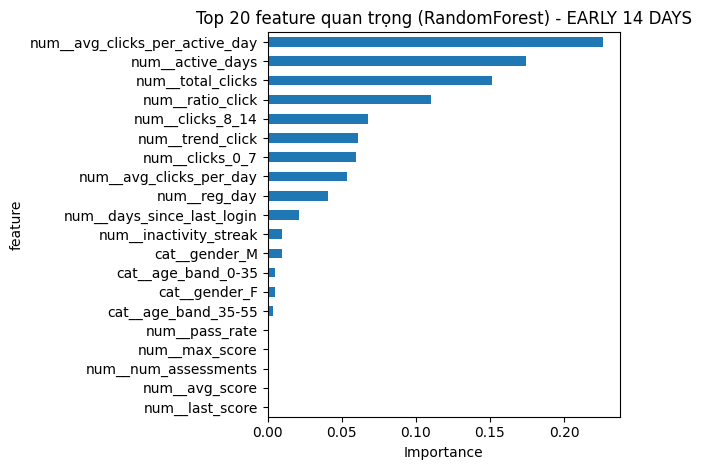

In [12]:
rf_clf = RandomForestClassifier(
    criterion="gini",
    max_depth=3,
    min_samples_leaf=10,
    min_samples_split=50,
    n_estimators=50,
)
rf_pipe = Pipeline(
    steps=[
        ("preprocess", preprocessor),
        ("classifier", rf_clf),
    ]
)
rf_pipe.fit(X_train, y_train)

feature_names = rf_pipe.named_steps["preprocess"].get_feature_names_out()
importances = rf_pipe.named_steps["classifier"].feature_importances_

fi = pd.DataFrame(
    {"feature": feature_names, "importance": importances}
).sort_values("importance", ascending=False)

top_n = 20
plt.figure()
fi.head(top_n).set_index("feature")["importance"].plot(kind="barh")
plt.gca().invert_yaxis()
plt.title(f"Top {top_n} feature quan trọng (RandomForest) - EARLY 14 DAYS")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()


In [13]:

results = {}

for name, clf in models.items():
    pipe = Pipeline(
        steps=[
            ("preprocess", preprocessor),
            ("classifier", clf),
        ]
    )

    pipe.fit(X_train, y_train)

    y_pred = pipe.predict(X_test)
    y_proba = pipe.predict_proba(X_test)[:, 1]

    accuracy = accuracy_score(y_test, y_pred)
    precision_1, recall_1, f1_1, support_1 = precision_recall_fscore_support(
        y_test, y_pred, labels=[1], average=None
    )
    roc_auc = roc_auc_score(y_test, y_proba)
    avg_prec = average_precision_score(y_test, y_proba)

   

    results[name] = {
        "accuracy": accuracy,
        "precision_1": precision_1[0],
        "recall_1": recall_1[0],
        "f1_1": f1_1[0],
        "roc_auc": roc_auc,
        "avg_precision": avg_prec,
        "support_1": support_1[0],
    }

results_df = pd.DataFrame(results).T
results_df


/Users/nami/lms/engtastic_ai/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(


,accuracy,precision_1,recall_1,f1_1,roc_auc,avg_precision,support_1
LogisticRegression,0.717087,0.466165,0.673913,0.551111,0.795160,0.674431,92.0
RandomForest,0.792717,0.636364,0.456522,0.531646,0.765238,0.651214,92.0
GradientBoosting,0.803922,0.711538,0.402174,0.513889,0.749323,0.603690,92.0
MLPClassifier,0.823529,0.871795,0.369565,0.519084,0.807834,0.694280,92.0
